In [5]:
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = 0 if torch.cuda.is_available() else -1

checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint).to(device)




In [11]:
import os
from PIL import Image
import numpy as np
import cv2

input_dir = "val_selection_cropped/test_images_dontuse"  # Replace with your input directory
output_dir = "val_selection_cropped/test_depth_estimates_dontsave"  # Replace with your output directory

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        image_path = os.path.join(input_dir, filename)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        w, h = image.size  # PIL gives (width, height)

        inputs = processor(images=image, return_tensors="pt").to(device)

        # Perform depth estimation
        with torch.no_grad():
            outputs = model(**inputs) # 

        post_processed = processor.post_process_depth_estimation(outputs,
                                                                 target_sizes=[(h, w)],  # ensure SAME resolution as RGB
                                                                 )
        predicted_depth = post_processed[0]["predicted_depth"]  # (H, W), float32-ish

        # move to cpu + numpy
        depth_np = predicted_depth.detach().cpu().numpy().astype("float32")
        
        # per-image normalization to [0,1] for stability -- These are NOT true depths, only structure
        d_min, d_max = depth_np.min(), depth_np.max()
        depth_np = (depth_np - d_min) / (d_max - d_min + 1e-8)
        print(depth_np)
        
        # Construct output path and save
        output_filename = os.path.splitext(filename)[0] + "_depth_estimate.npy"
        output_path = os.path.join(output_dir, output_filename)
        np.save(output_path, depth_np)

        print(f"Processed {filename} and saved depth map to {output_path}")

[[0.03705769 0.03705769 0.03705769 ... 0.37289307 0.3738401  0.34789085]
 [0.03705769 0.03705769 0.03705769 ... 0.3736009  0.3718931  0.3728388 ]
 [0.03705769 0.03705769 0.03705769 ... 0.37300223 0.3727417  0.37171575]
 ...
 [0.94134456 0.94124705 0.941298   ... 0.956159   0.9546872  0.9531424 ]
 [0.94582736 0.9454603  0.9457706  ... 0.9573648  0.9584937  0.9572368 ]
 [0.95183784 0.9489761  0.9507985  ... 0.9637961  0.9611873  0.9636227 ]]
Processed 2011_09_26_drive_0002_sync_image_0000000005_image_02.png and saved depth map to val_selection_cropped/test_depth_estimates_dontsave\2011_09_26_drive_0002_sync_image_0000000005_image_02_depth_estimate.npy
[[0.16633014 0.16283083 0.16515808 ... 0.21263921 0.21035601 0.2000981 ]
 [0.16420071 0.16533981 0.16394137 ... 0.21236688 0.21228176 0.21415375]
 [0.16367616 0.16297132 0.1623709  ... 0.21209434 0.21264262 0.21332207]
 ...
 [0.9478106  0.9474166  0.94728565 ... 0.90529877 0.90512806 0.90370935]
 [0.9507     0.95110625 0.951986   ... 0.9029

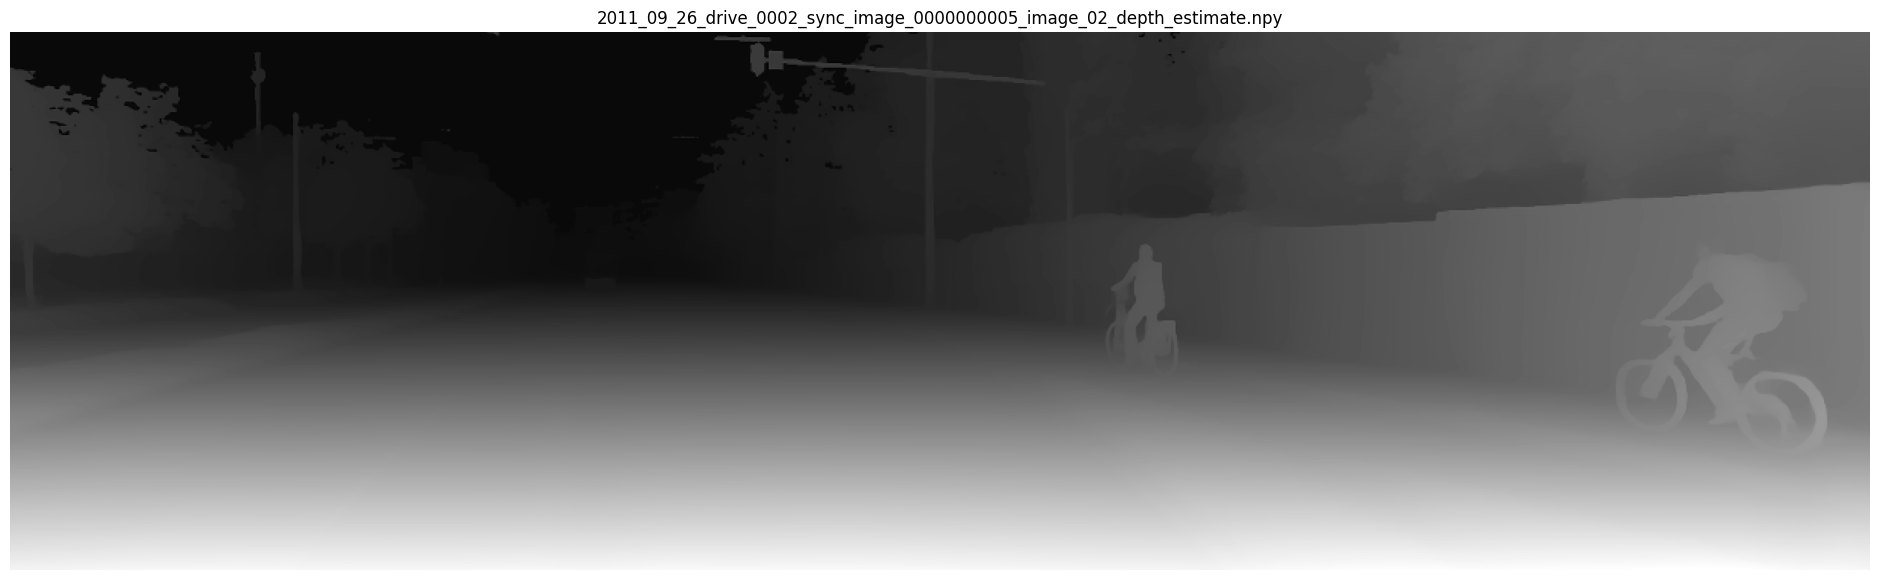

In [ ]:
# Visualize .npy files in full resolution grayscale from dir: val_selection_cropped/depth_estimates

import matplotlib.pyplot as plt
import os
import numpy as np

depth_estimates_dir = "val_selection_cropped/depth_estimates"



for i, filename in enumerate(os.listdir(depth_estimates_dir)):
    if i==1: break

    if filename.endswith(".npy"):
        depth_map = np.load(os.path.join(depth_estimates_dir, filename))
        plt.figure(figsize=(24, 18))
        plt.imshow(depth_map, cmap='gray')
        plt.title(filename)
        plt.axis('off')
        plt.show()

Train samples: 800, Val samples: 200


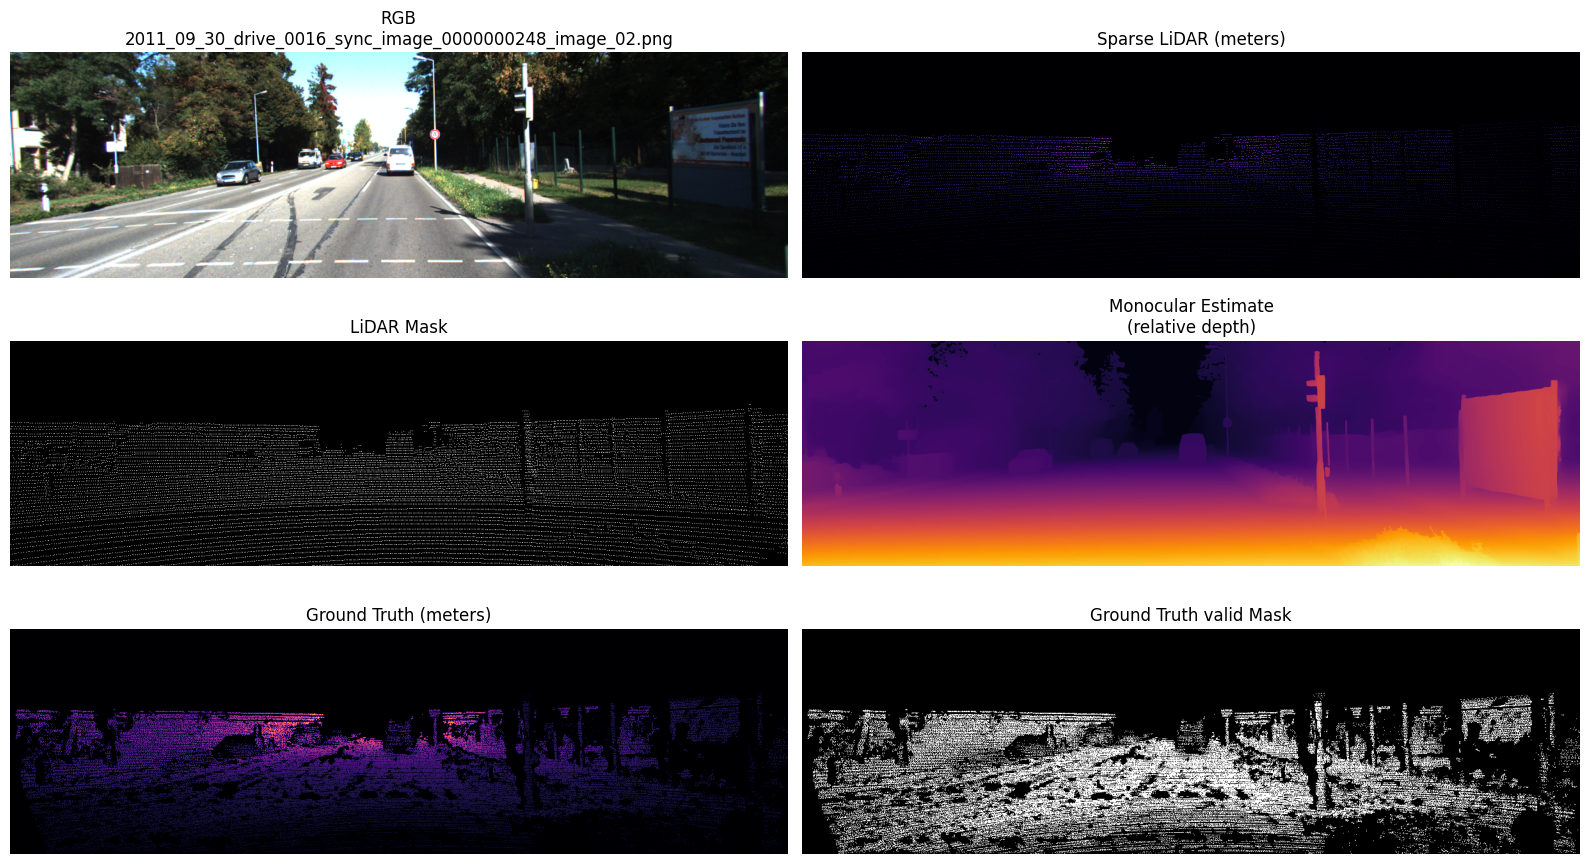

In [26]:
# test data loaders 

from data import KittiDepthCropped

import numpy as np
from torch.utils.data import DataLoader

root = "val_selection_cropped"

# First, create a "base" dataset to know how many samples there are
base_dataset = KittiDepthCropped(root)

num_samples = len(base_dataset)
indices = np.arange(num_samples)
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# ImageNet RGB stats
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_dataset = KittiDepthCropped(
    root,
    split_indices=train_indices,
    rgb_mean=imagenet_mean,
    rgb_std=imagenet_std,
)

val_dataset = KittiDepthCropped(
    root,
    split_indices=val_indices,
    rgb_mean=imagenet_mean,
    rgb_std=imagenet_std,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

import matplotlib.pyplot as plt

def visualize_sample(loader, batch_idx=0, sample_idx=0):
    """
    Visualize ONE sample from ONE batch.
    loader: DataLoader object
    batch_idx: which batch to load
    sample_idx: which sample in the batch
    """

    # Find the batch
    for i, batch in enumerate(loader):
        if i == batch_idx:
            break
    else:
        print(f"Batch {batch_idx} not found.")
        return

    # Extract the sample
    rgb = batch["rgb"][sample_idx].cpu().numpy()           # (3, H, W)
    mono = batch["mono"][sample_idx].cpu().numpy()         # (1, H, W)
    sparse = batch["sparse"][sample_idx].cpu().numpy()     # (1, H, W)
    sparse_mask = batch["sparse_mask"][sample_idx].cpu().numpy()
    gt = batch["gt"][sample_idx].cpu().numpy()
    gt_mask = batch["gt_mask"][sample_idx].cpu().numpy()

    sample_id = batch["id"][sample_idx]

    # denormalize
    imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    imagenet_std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    rgb = rgb * imagenet_std + imagenet_mean

    # clamp to [0,1] just in case
    rgb = np.clip(rgb, 0.0, 1.0)

    # CHW -> HWC
    rgb_img = rgb.transpose(1, 2, 0)

    # Prepare figure
    fig, axes = plt.subplots(3, 2, figsize=(16, 9))
    

    # --- RGB ---
    axes[0, 0].imshow(rgb_img)
    axes[0, 0].set_title(f"RGB\n{sample_id}")
    axes[0, 0].axis("off")

    # --- Ground Truth Mask ---
    axes[0, 1].imshow(gt_mask[0], cmap="gray",
                   vmin=0,
                   vmax=np.nanmax(gt_mask[0]))
    axes[0, 1].set_title("Sparse LiDAR (meters)")
    axes[0, 1].axis("off")

     # --- Sparse LiDAR Depth ---
    axes[0, 1].imshow(sparse[0], cmap="magma",
                      vmin=0, vmax=np.nanmax(sparse[0]))
    axes[0, 1].set_title("Sparse LiDAR (meters)")
    axes[0, 1].axis("off")

    # --- Sparse Mask ---
    axes[1, 0].imshow(sparse_mask[0], cmap="gray")
    axes[1, 0].set_title("LiDAR Mask")
    axes[1, 0].axis("off")

    # --- Monocular Prior (0–1 normalized) ---
    axes[1, 1].imshow(mono[0], cmap="inferno", vmin=0, vmax=1)
    axes[1, 1].set_title("Monocular Estimate\n(relative depth)")
    axes[1, 1].axis("off")

    # --- Ground Truth Depth ---
    axes[2, 0].imshow(gt[0], cmap="magma",
                   vmin=0,
                   vmax=np.nanmax(gt[0]))
    axes[2, 0].set_title("Ground Truth (meters)")
    axes[2, 0].axis("off")

    # --- Ground Truth Mask ---
    axes[2, 1].imshow(gt_mask[0], cmap="gray",
                   vmin=0,
                   vmax=np.nanmax(gt_mask[0]))
    axes[2, 1].set_title("Ground Truth valid Mask")
    axes[2, 1].axis("off")
    

    plt.tight_layout()
    plt.show()

visualize_sample(train_loader)

